In [57]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
import re
import nltk
from nltk.corpus import cmudict
import torch
from torch.utils.data import Dataset, DataLoader
import random

In [58]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [59]:
def load_and_preprocess_data(filename="shakespeare.txt"):
    """
    Load Shakespeare sonnets and perform preprocessing
    """
    with open(filename, 'r', encoding='utf-8') as f:
        data = f.read()

    # Basic preprocessing - convert to lowercase and clean
    data = data.lower()

    # Get unique characters
    chars = sorted(list(set(data)))
    data_size, vocab_size = len(data), len(chars)

    print("----------------------------------------")
    print(f"Data has {data_size} characters, {vocab_size} unique")
    print(f"Characters: {repr(''.join(chars))}")
    print("----------------------------------------")

    return data, chars, data_size, vocab_size

In [60]:
def create_mappings(chars):
    """Create character to index and index to character mappings"""
    char_to_ix = {ch: i for i, ch in enumerate(chars)}
    ix_to_char = {i: ch for i, ch in enumerate(chars)}
    return char_to_ix, ix_to_char

In [61]:
def text_to_indices(data, char_to_ix):
    """Convert text data to tensor of indices"""
    indices = [char_to_ix[ch] for ch in data]
    return torch.tensor(indices, dtype=torch.long).to(device)

In [62]:
class ShakespeareDataset(Dataset):
    def __init__(self, data_tensor, sequence_length=40):
        self.data = data_tensor
        self.seq_len = sequence_length

    def __len__(self):
        return len(self.data) - self.seq_len

    def __getitem__(self, idx):
        input_seq = self.data[idx:idx + self.seq_len]
        target_seq = self.data[idx + 1:idx + self.seq_len + 1]
        return input_seq, target_seq

In [63]:
class ShakespeareRNN(nn.Module):
    def __init__(self, vocab_size, embedding_size=128, hidden_size=128, num_layers=1, dropout=0.2):
        super(ShakespeareRNN, self).__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_size)

        # LSTM layer(s)
        self.lstm = nn.LSTM(
            input_size=embedding_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )

        # Dropout layer
        self.dropout = nn.Dropout(dropout)

        # Output layer
        self.decoder = nn.Linear(hidden_size, vocab_size)

    def forward(self, input_seq, hidden_state=None):
        batch_size = input_seq.size(0)

        # Embedding
        embedded = self.embedding(input_seq)

        # LSTM forward pass
        lstm_out, hidden_state = self.lstm(embedded, hidden_state)

        # Apply dropout
        lstm_out = self.dropout(lstm_out)

        # Decode to vocabulary size
        output = self.decoder(lstm_out)

        return output, hidden_state

    def init_hidden(self, batch_size):
        """Initialize hidden state"""
        hidden = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        cell = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        return (hidden, cell)

In [64]:
def train_model(model, dataset, epochs=20, batch_size=32, learning_rate=0.001):
    """Train the RNN model"""
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model.train()
    losses = []

    for epoch in range(epochs):
        total_loss = 0
        num_batches = 0

        for batch_idx, (input_seq, target_seq) in enumerate(dataloader):
            # Initialize hidden state
            hidden = model.init_hidden(input_seq.size(0))

            # Forward pass
            output, hidden = model(input_seq, hidden)

            # Reshape for loss calculation
            output = output.reshape(-1, model.vocab_size)
            target_seq = target_seq.reshape(-1)

            # Calculate loss
            loss = criterion(output, target_seq)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()

            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)

            optimizer.step()

            total_loss += loss.item()
            num_batches += 1

        avg_loss = total_loss / num_batches
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss:.6f}")

    return losses

In [65]:
def generate_text(model, seed_text, char_to_ix, ix_to_char, length=200, temperature=1.0):
    """Generate text using the trained model"""
    model.eval()

    # Convert seed text to indices
    input_seq = [char_to_ix.get(ch, 0) for ch in seed_text.lower()]
    input_seq = torch.tensor(input_seq, dtype=torch.long).unsqueeze(0).to(device)

    generated_text = seed_text
    hidden = model.init_hidden(1)

    with torch.no_grad():
        # Process seed text
        for i in range(len(input_seq[0]) - 1):
            output, hidden = model(input_seq[:, i:i+1], hidden)

        # Generate new characters
        for _ in range(length):
            # Get last output
            output, hidden = model(input_seq[:, -1:], hidden)
            output = output.squeeze(0).squeeze(0)

            # Apply temperature
            output = output / temperature

            # Sample from distribution
            probabilities = F.softmax(output, dim=0)
            char_idx = torch.multinomial(probabilities, 1).item()

            # Convert to character and append
            char = ix_to_char[char_idx]
            generated_text += char

            # Update input sequence
            input_seq = torch.cat([input_seq, torch.tensor([[char_idx]]).to(device)], dim=1)
            input_seq = input_seq[:, -40:]  # Keep only last 40 characters

    return generated_text

----------------------------------------
Data has 98029 characters, 48 unique
Characters: "\n !'(),-.0123456789:;?abcdefghijklmnopqrstuvwxyz"
----------------------------------------
Model parameters: 276,528
Starting training...
Epoch 1/15, Average Loss: 1.639945
Epoch 2/15, Average Loss: 1.363705
Epoch 3/15, Average Loss: 1.275555
Epoch 4/15, Average Loss: 1.226239
Epoch 5/15, Average Loss: 1.193728
Epoch 6/15, Average Loss: 1.172833
Epoch 7/15, Average Loss: 1.155991
Epoch 8/15, Average Loss: 1.143989
Epoch 9/15, Average Loss: 1.133667
Epoch 10/15, Average Loss: 1.125280
Epoch 11/15, Average Loss: 1.117663
Epoch 12/15, Average Loss: 1.111025
Epoch 13/15, Average Loss: 1.104908
Epoch 14/15, Average Loss: 1.099499
Epoch 15/15, Average Loss: 1.095490


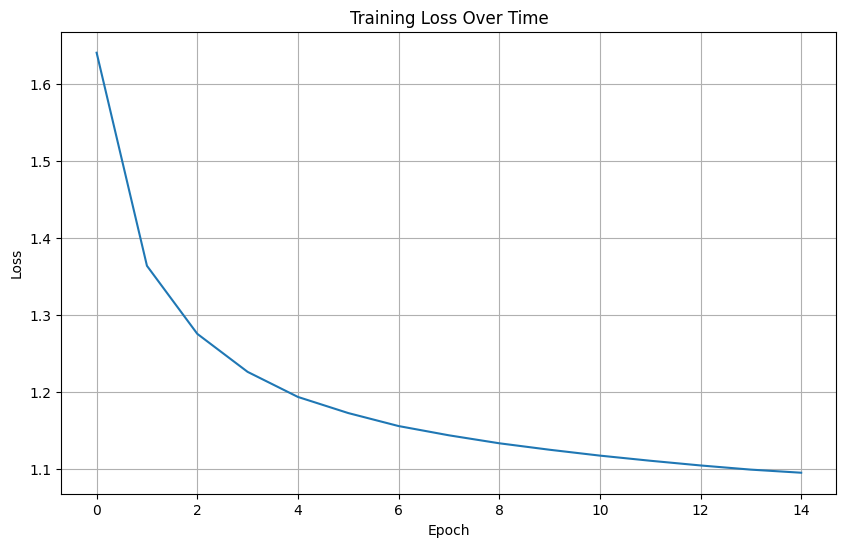


GENERATED POEMS WITH DIFFERENT TEMPERATURES

Temperature: 0.25
----------------------------------------
shall i compare thee to a summer's day?
thou art as form of all the world away,
to the world will be the self-love to thee,
  that i have sworn thee in their spirits to thee,
  then thou dost thou my love is as form to be so long,
that they grace and for the summer is see the sun
delights to make of thee, and therefore to me that which i 
----------------------------------------

Temperature: 0.75
----------------------------------------
shall i compare thee to a summer's day?
thou art a counterpart, for men then change this that struight befits,
so long as thine, that beauty which those friends that depart,
to thine own new hath my spare shall be forgots,
if thou out thy dure the shape to compounds lost.
then that sweets mine own will with thee report to my worth to me s
----------------------------------------

Temperature: 1.5
----------------------------------------
shall i comp

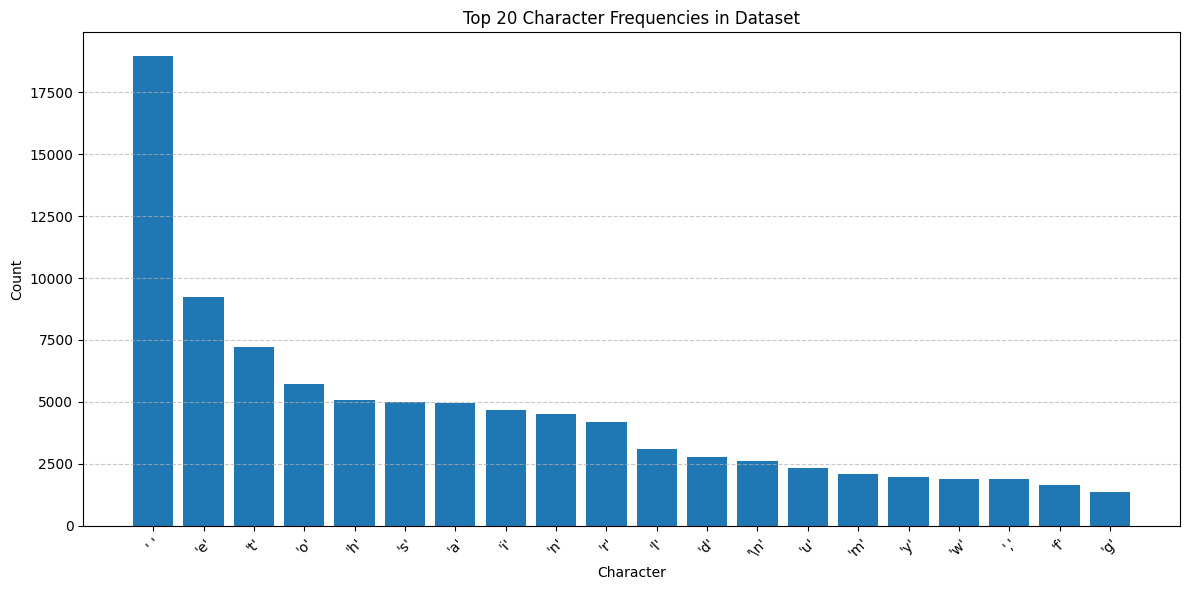

In [67]:
data, chars, data_size, vocab_size = load_and_preprocess_data()
char_to_ix, ix_to_char = create_mappings(chars)
data_tensor = text_to_indices(data, char_to_ix)

# Create dataset
sequence_length = 40
dataset = ShakespeareDataset(data_tensor, sequence_length)

# Create model
model = ShakespeareRNN(
    vocab_size=vocab_size,
    embedding_size=128,
    hidden_size=128,
    num_layers=2,
    dropout=0.2
).to(device)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# Train model
print("Starting training...")
losses = train_model(model, dataset, epochs=15, batch_size=32, learning_rate=0.002)

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.title('Training Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# Generate text with different temperatures
seed_text = "shall i compare thee to a summer's day?\n"
temperatures = [0.25, 0.75, 1.5]

print("\n" + "="*60)
print("GENERATED POEMS WITH DIFFERENT TEMPERATURES")
print("="*60)

for temp in temperatures:
    print(f"\nTemperature: {temp}")
    print("-" * 40)
    generated = generate_text(
        model, seed_text, char_to_ix, ix_to_char,
        length=300, temperature=temp
    )
    print(generated)
    print("-" * 40)

# Analyze character frequencies
print("\nCharacter Frequency Analysis:")
char_counts = Counter(data)
char_freq = dict(sorted(char_counts.items(), key=lambda x: x[1], reverse=True))

plt.figure(figsize=(12, 6))
chars_to_plot = list(char_freq.keys())[:20]  # Top 20 characters
counts_to_plot = [char_freq[c] for c in chars_to_plot]

plt.bar(range(len(chars_to_plot)), counts_to_plot)
plt.title("Top 20 Character Frequencies in Dataset")
plt.xlabel("Character")
plt.ylabel("Count")
plt.xticks(range(len(chars_to_plot)), [repr(c) for c in chars_to_plot], rotation=45)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Character Frequency Analysis:


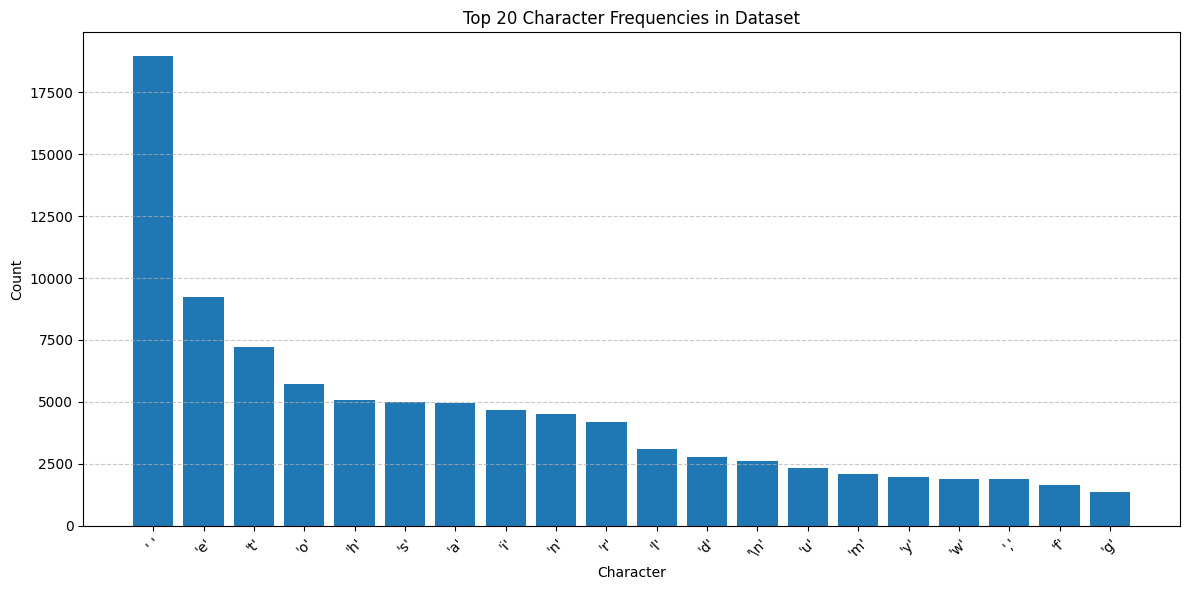

In [66]:
print("\nCharacter Frequency Analysis:")
char_counts = Counter(data)
char_freq = dict(sorted(char_counts.items(), key=lambda x: x[1], reverse=True))

plt.figure(figsize=(12, 6))
chars_to_plot = list(char_freq.keys())[:20]  # Top 20 characters
counts_to_plot = [char_freq[c] for c in chars_to_plot]

plt.bar(range(len(chars_to_plot)), counts_to_plot)
plt.title("Top 20 Character Frequencies in Dataset")
plt.xlabel("Character")
plt.ylabel("Count")
plt.xticks(range(len(chars_to_plot)), [repr(c) for c in chars_to_plot], rotation=45)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()